# Model Selection and Evaluation

## 1. Import packages

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import matplotlib.dates as mdates

from prophet import Prophet
import plotly.express as px
from prophet.plot import add_changepoints_to_plot, plot_cross_validation_metric
from prophet.diagnostics import cross_validation, performance_metrics


import itertools


from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

%matplotlib inline


warnings.filterwarnings('ignore')

import trafficModules as tm

## 2. Set basic parameters for cross-validation cutoffs and the traffic counting station

### The analysis included 16 traffic counting stations in Hamburg (5 city center junctions, 8 roads in the suburbs and 3 motorway feeders. The inner city counting station 1061 was used for intial EDA and the developement of the baseline and Prophet model 

In [ ]:
### Choose the traffic counting station "Zählstelle" and cutoff date for first train/test split
zähl = '1061'

### Cutoff to save some data for testing later
cutoff_1 = '2021-12-31'

### Cutoffs for cross-validation within the training step
#cv_cutoffs = pd.to_datetime(['2020-12-31', '2021-01-31',' 2021-02-28', '2021-03-31', '2021-04-30', '2021-05-31', '2021-06-30',
              #'2021-07-31', '2021-08-31', '2021-09-30', '2021-10-31', '2021-11-30',])

cv_cutoffs = pd.to_datetime(['2020-12-15',' 2021-03-15', '2021-06-30','2021-09-15',])


### Prediction horizon
horizon=30
#31


## 3. Import and filter data for traffic counting station and make daily sums

### Traffic data was available on an hourly basis, but was aggregated to daily sums for final analysis

In [ ]:
df = pd.read_csv('../data/compiled-zähstellen.csv',index_col=0, parse_dates=True)


### Filter for Zählstelle
df = df.query(f'Zählstelle == {zähl}').asfreq(freq="H").reset_index()
# df.Zählstelle[:] = zähl

##Drop unused columns
df.drop(['Zählstelle','PKW','LKW'],axis=1, inplace=True)

## Rename columns for Prophet
df.rename(columns={'Gesamt': 'y', 'datetime': 'ds'}, inplace=True)

### Which hours have NaNs?
df['NaN'] = df['y'].isna()

### Set the index again to 'ds' and make daily sums of traffic and hourly NaNs
df_daily = df.set_index('ds').resample('d').sum()

### If a day has more than 2 hourly NaNs, replace the day with nan
df_daily.loc[df_daily['NaN'] > 2,f'y'] = np.nan
df_daily.drop(f'NaN', axis=1,inplace=True)

## Overwrite dataframe of all Zählstellen with chosen Zählstelle in daily sums
df = df_daily.reset_index()

## Print head
df.head(3)

## 4. Test / train splits 

In [ ]:
# Copy the data for splitting
y = df.copy(deep=True)

#Make first test/train cutoff. Test is not used for cross-validation
y_train = y[y.ds <= cutoff_1]
y_test = y[y.ds > cutoff_1]

## 5. Calculating Baseline Model

### As baseline model the traffic density of the last equivalent weekday was chosen. Due to high seasonality this baseline model performs surprisingly well

In [ ]:
#Interpolate missing values, but only for the baseline model
interpol = tm.InterpolateImputer()
y_train_base = interpol.transform(y_train)


df_cv,df_metrics = tm.cross_val_baseline(y_train_base, cutoffs=cv_cutoffs, horizon=horizon)

In [ ]:
df_cv

In [ ]:
# Writing baseline calculation to csv
df_cv.to_csv('../data/baseline_00.csv',index=False)

## 6. Calculating Final Prophet Model with Cross Validation and Grid Search 

### Writing Helper Functions for calculation of the model

In [ ]:
### Function to log transform y (applid inside do_experiment function). Was not used in final model
def log_y(y):
    # Create a copy of the data
    y_log = y.copy()
    # Create the log scale data by taking the natual log of the stock prices.
    y_log['y_log'] = np.log(y['y'])
    # Delete the unscaled y and rename the log scale stock price to y
    y_log = y_log.drop('y', axis=1).rename(columns={'y_log': 'y'})

    return y_log

In [ ]:
def do_experiment(y,exp_name,params,add_reg_list=None, ### List of column-names from y which are additional regressors
                  holidays=None, logarithmic=False, country_hol=None):

    if logarithmic == True: ### Log Transform y-data if defined for experiment
        y = log_y(y)

    m = Prophet(**params, daily_seasonality=False,holidays=holidays) ### Instance of Prophet Model with given arguments

    if country_hol: ### Add pre-defined German holidays instead of no holidays or extended holiday data (holidays = above)
        m.add_country_holidays(country_name=country_hol)
    
    if (add_reg_list): ### Add further features as regressors as defined in add_reg_list
        for col in add_reg_list:
            m.add_regressor(col)
    
    with tm.suppress_stdout_stderr():
        m.fit(y) ### fit model
    
    with tm.suppress_stdout_stderr(): ### Perform cross validation as defined with cv_cutoffs
       df_cv = cross_validation(m, cutoffs=cv_cutoffs, horizon = f'{horizon} days', parallel="processes")
    
    if logarithmic == True: ### Transform Log-Scaled data back to actual trafic data
        df_cv["y"] = np.exp(df_cv["y"])
        df_cv["yhat"] = np.exp(df_cv["yhat"])

    ### Add a column for each tuned hyperparameter and its value
    param_vals = []
    for key in params:
        df_cv[key] = params[key]
    
    ### Add experiment name
    df_cv["experiment_name"] = exp_name

    return df_cv

In [ ]:
def do_multi_experiments(y,exp_name,all_params,add_reg_list=None,holidays=None,logarithmic=False
                         ,country_hol=None):
    i = 0
    mapes = [] ### List of MAPE values for experiment run
    how_many = len(all_params) ### Number of experiments to run = N of hyperparameter-combinations
    print(f"Running {how_many} experiments") 

    if logarithmic == True: ### Add log_ to experiment name to indicate the use of logarithmic y-data
        exp_name = "log_" + exp_name

    for params in all_params: ### Loop through all hyperparameter-value-combinations
        
        ### Do single experiment and save y, yhat and hyperparameter-values in a df
        df_cv = do_experiment(y=y,exp_name=exp_name,params=params,
                      add_reg_list=add_reg_list,holidays=holidays,logarithmic=logarithmic,
                      country_hol=country_hol)
        
        ### Save as a single .csv
        filename = f"../data/{exp_name}_{str(i).zfill(2)}.csv"
        df_cv.to_csv(filename,index=False)
    
        ### Calculate MAPE
        mape_exp = mean_absolute_percentage_error(df_cv.y,df_cv.yhat.round())
        mapes.append(mape_exp)

        ### Print experiment Summary (hyperparameter-values, MAPE)
        print(f'Finished with experiment {str(i).zfill(1)} of {how_many}, MAPE:{round(mape_exp,2)}')
        

        i+=1

    ### Print summary of the best experiment
    mapes = np.array(mapes)
    min_indx = np.argmin(mapes)
    print("")
    print("")
    print("-------"*10)
    print("-------"*10)
    print("RESULTS")
    print("-------"*10)
    print("-------"*10)
    print(f'Best experiment was {min_indx} with MAPE {mapes[min_indx]} and following parameters')
    print(all_params[min_indx])

### Parameter grid - developed through random search on Zählstelle 1061

In [ ]:
param_grid = {  
    'changepoint_prior_scale': [5e-1,1,2],
    'seasonality_prior_scale': [1e-1,1,5],
    'holidays_prior_scale':    [1e-1,1,10],
    'seasonality_mode': ['additive','multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]

### Calculating Prophet model for chosen Zählstelle with built-in public holidays for Germany

In [ ]:
do_multi_experiments(y_train,exp_name='holsDE-A',
                     country_hol='DE')

The table below shows the model computed for all 16 traffic counting stations. For evaluation the error metric Mean Absolute Percentage Error (MAPE) was used. The MAPE of the model beats the baseline MAPE for every counting station

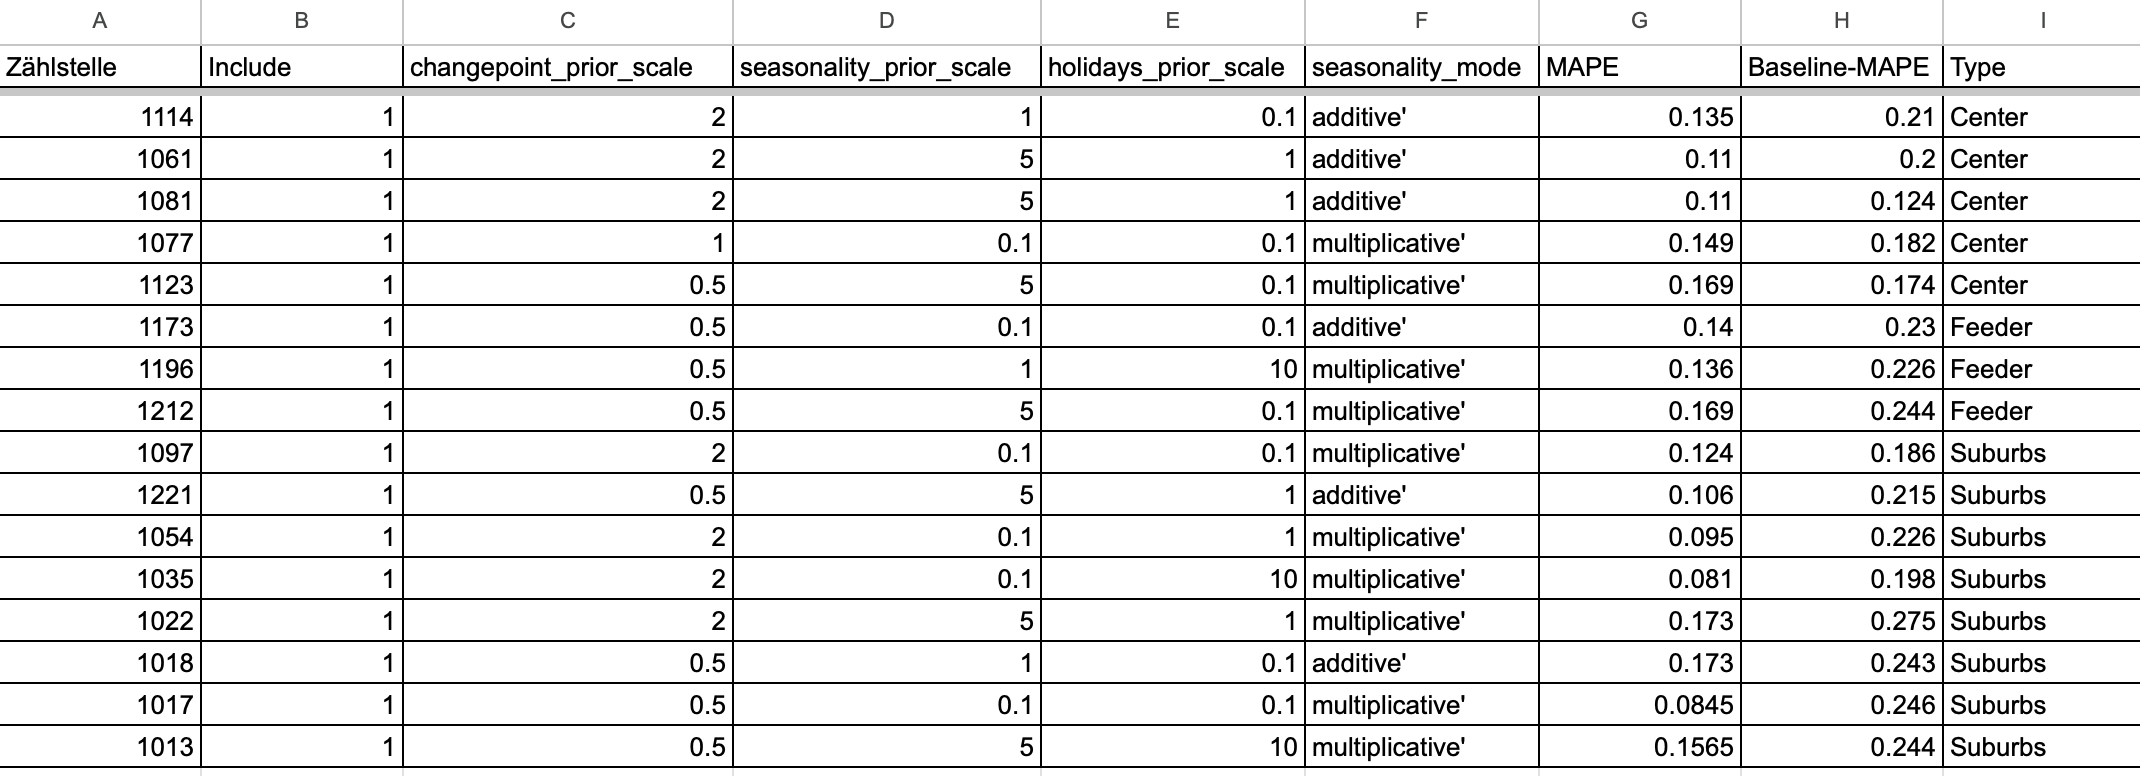